<a href="https://colab.research.google.com/github/JayeonKangNature/2022_Summer_Internship/blob/main/Task/Task_2_Dog_VS_Cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<font size = 6>Task 2: Dog VS Cat** <br>
<font size=3>Jayeon Kang

---



## Environment Set-up

In [ ]:
# The Python Imaging Library is needed to display images
!pip install pillow
# Import base packages
import os
import zipfile
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
# Setup plots
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()
# Import ML packages (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F # for activation function
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

%load_ext tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
PyTorch version: 1.12.0+cu113


In [ ]:
# Mounting
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Utilify functions

In [ ]:
def plot_decision_boundary(pred_func, X, y, figure=None):
    """Plot a decision boundary"""

    if figure is None:  # If no figure is given, create a new one
        plt.figure()
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)

## Step 1: Data loading

In [ ]:
# Downloading our example data, a .zip of 2,000 JPG pictures, and extracting it locally in `/tmp`
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip
# Extracting zip file to the base directory `/tmp/cats_and_dogs_filtered`
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

--2022-07-15 06:17:40--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   273MB/s    in 0.2s    

2022-07-15 06:17:40 (273 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



## Step 2: Explore Data

Training cat images: 1000
Training dog images: 1000
Validation cat images: 500
Validation dog images: 500
['cat.994.jpg', 'cat.95.jpg', 'cat.29.jpg', 'cat.559.jpg', 'cat.168.jpg', 'cat.430.jpg', 'cat.980.jpg', 'cat.80.jpg', 'cat.236.jpg', 'cat.813.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


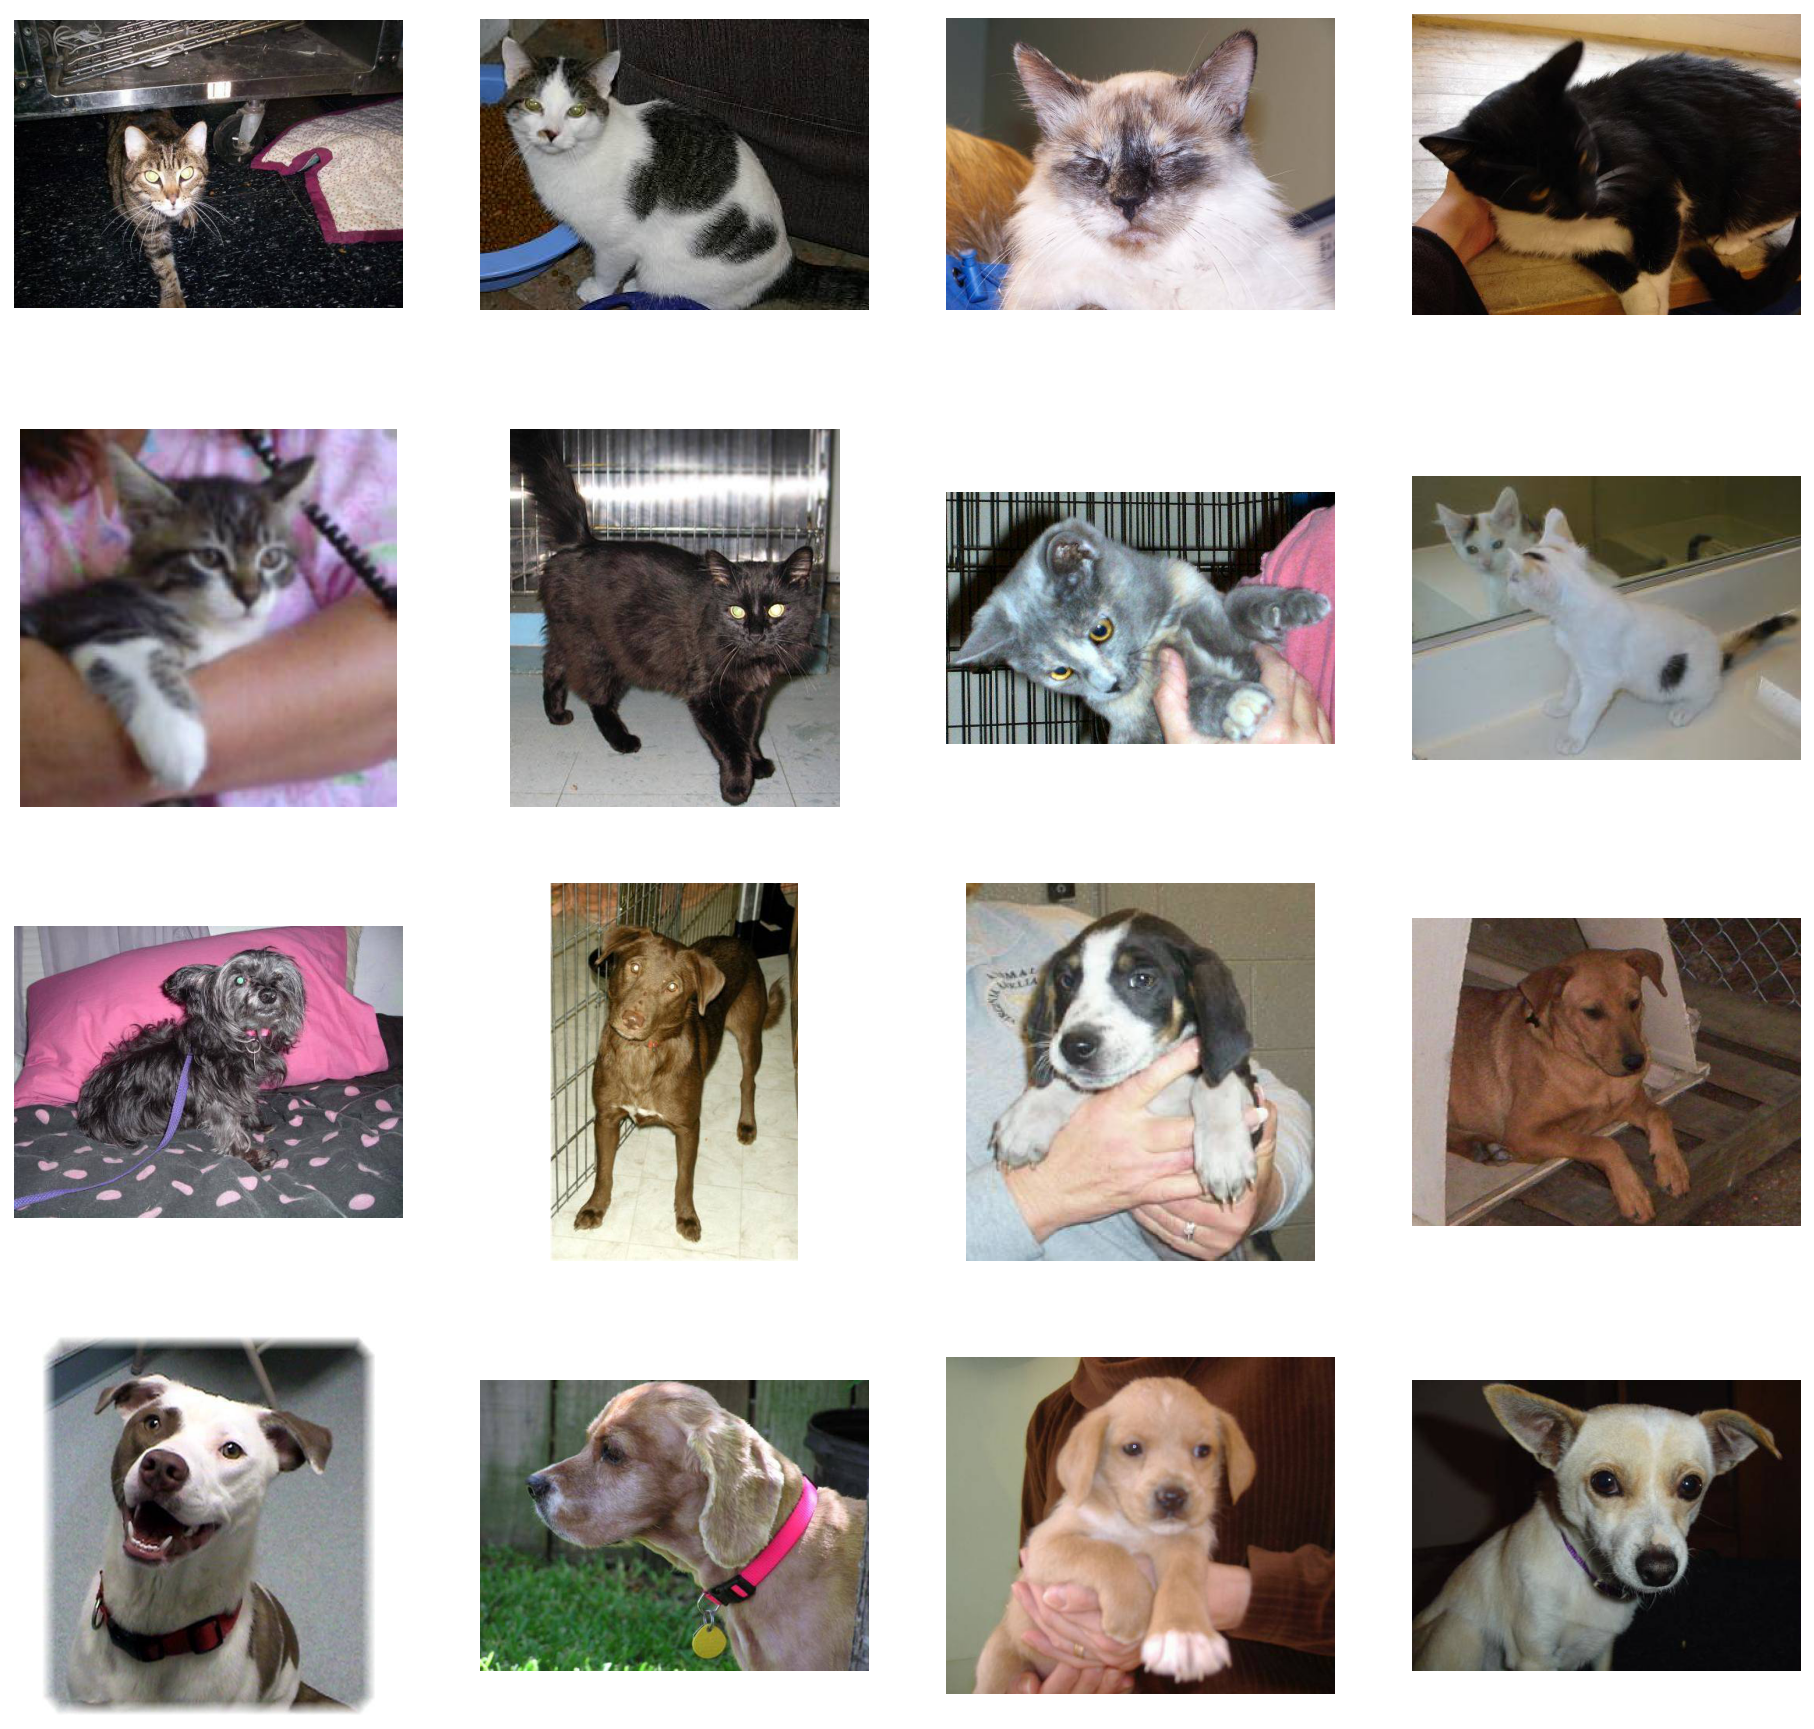

In [ ]:
print(f'Training cat images: {len(os.listdir(train_cats_dir))}')
print(f'Training dog images: {len(os.listdir(train_dogs_dir))}')
print(f'Validation cat images: {len(os.listdir(validation_cats_dir))}')
print(f'Validation dog images: {len(os.listdir(validation_dogs_dir))}')

# Display some images files for cats and dogs
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])
train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Step 3: Preparing data

### Question
Prepare the data by resizing all images to 150x150 and normalizing them.<br>
Create a DataLoader for training data and another one for validation data.

In [ ]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

valid_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

Resize – Size to which the input image is to be resized.<br>
- When input is (h, w): size is a sequence like (h, w), where h and w are the height and width of the output image.
- When input is int: If size is an int, then the resized image will be a square image.<br>

ToTensor() - Converts a PIL Image or numpy.ndarray (H x W x C)

In [ ]:
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(validation_dir, transform=valid_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=20, num_workers=10, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=20, num_workers=10, shuffle=False)

class_names = train_data.classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(class_names)

['cats', 'dogs']


## Step 4: Training a model

## TASK

**Create a CNN model able to be trained on 150x150x3 images. Instantiate it into the `net` variable.**

**Convolutional Network**

In [ ]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

net = ConvolutionalNetwork()
print(net)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


<font size = 4> 1) Create Loss and Optimizer function

In [ ]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

<font size = 4> 2) Train

In [ ]:
print('number of data for train and validation')
print(len(train_data))
print(len(valid_data))

number of data for train and validation
2000
1000


<font size = 5>Version 1.

In [ ]:
epochs = 5

max_trn_batch = 800

train_losses = []
train_correct = []

for i in range(epochs):
    trn_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
      # b is just for print accuracy and limiting number of batches

        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1

        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%100 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

print('finish')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch:  0  batch:  100 [  1000/8000]  loss: 0.52605242  accuracy: 116.000%
epoch:  1  batch:  100 [  1000/8000]  loss: 0.62183094  accuracy: 130.500%
epoch:  2  batch:  100 [  1000/8000]  loss: 0.46990579  accuracy: 138.500%
epoch:  3  batch:  100 [  1000/8000]  loss: 0.63939995  accuracy: 146.100%
epoch:  4  batch:  100 [  1000/8000]  loss: 0.34437370  accuracy: 149.200%
finish


<font size = 5> Version 2.

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times
    total = 0
    trn_correct = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 100 == 0:
          print(f'Current accuracy: {100 * correct/ total}')
print('Finish')

## Step 5: Evaluating the model

## TASK

**Compute accuracy on validation data. Store it into the `val_acc` variable.**

**Validation accuracy should be > 70%.**


In [ ]:
net.eval()
max_tst_batch = 300
correct = 0
total = 0
with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_acc = 100 * correct / total
print(val_acc)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


50.0


In [ ]:
# Assert final accuracy
assert val_acc > 0.70